In [1]:
#Import necessary libraries 
import numpy as np
import pandas as pd
import datetime as dt 
import yfinance as yf
import matplotlib.pyplot as plt 
from scipy.stats import norm

# **Value at Risk Model**
The following project first demonstrates the construction of a Value at Risk(VAR) Model and ends with a python function that computes all steps of the VAR model all at once and returns a visualization of the model. The function recieves portfolio data saved in a csv file, then calcuates the portfolio value and the weights of each stock on the portfolio.Finally, the function returns a model with a specified confidence interval and the portfolios mimimum loss in a given period if a left tailed event occurs. The return values are represented logarithmically since the values can be more easily worked on.


In [2]:
#Sets period for 
years = 15
endDate = dt.datetime.now()
startDate = endDate - dt.timedelta(days=365*years)

In [3]:
#Largest snp500 etf, bond etf, commodity etf(gold), nasdaq etf, and vangaurds all world stock index
tickers = ['SPY','BND','GLD','QQQ','VTI']

In [4]:
#Dataframe for adj_close value is constructed and data is collected from yahoo finance, producing a pandas dataframe.
adj_close = pd.DataFrame()

for ticker in tickers: 
    data = yf.download(ticker, start = startDate, end = endDate,auto_adjust=False) #auto_adjust=False needed to get adj close
    adj_close[ticker] = data['Adj Close']

adj_close

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,SPY,BND,GLD,QQQ,VTI
Date,,,,,
2010-04-01,89.518478,51.560684,110.260002,42.048225,45.836887
2010-04-05,90.247993,51.260181,110.889999,42.441116,46.279823
2010-04-06,90.460800,51.299366,111.029999,42.563339,46.409641
2010-04-07,89.944023,51.495350,112.489998,42.458561,46.165283
2010-04-08,90.255608,51.469208,112.650002,42.554615,46.272198
...,...,...,...,...,...
2025-03-24,574.080017,73.000000,277.250000,490.660004,283.015045
2025-03-25,575.460022,73.089996,278.470001,493.459991,283.493317
2025-03-26,568.590027,72.930000,278.239990,484.380005,280.175018


In [5]:
#Daily returns are converted into logarithmic returns.
log_returns = np.log(adj_close/adj_close.shift(1))
log_returns = log_returns.dropna()
log_returns

,SPY,BND,GLD,QQQ,VTI
Date,,,,,
2010-04-05,0.008116,-0.005845,0.005697,0.009300,0.009617
2010-04-06,0.002355,0.000764,0.001262,0.002876,0.002801
2010-04-07,-0.005729,0.003813,0.013064,-0.002465,-0.005279
2010-04-08,0.003458,-0.000508,0.001421,0.002260,0.002313
2010-04-09,0.006546,0.001903,0.008750,0.005932,0.006744
...,...,...,...,...,...
2025-03-24,0.017750,-0.004374,-0.004462,0.021707,0.018335
2025-03-25,0.002401,0.001232,0.004391,0.005690,0.001688
2025-03-26,-0.012010,-0.002191,-0.000826,-0.018572,-0.011774


In [6]:
#Sample portfolio value and weights are initialized.
portfolio_value = 1000000
weights = np.array([1/len(tickers)]*len(tickers))
print(weights)

[0.2 0.2 0.2 0.2 0.2]


In [7]:
#The portfolio returns are given with correct weights applied from each ticker.
historical_returns = (log_returns * weights).sum(axis =1)
historical_returns

Date
2010-04-05    0.005377
2010-04-06    0.002012
2010-04-07    0.000681
2010-04-08    0.001789
2010-04-09    0.005975
                ...   
2025-03-24    0.009791
2025-03-25    0.003081
2025-03-26   -0.009075
2025-03-27    0.000059
2025-03-28   -0.010805
Length: 3771, dtype: float64

In [8]:
#A window for the VaR model is created, in this case a 5-day VaR model is being established. The returns over the period are provided.
days = 5
range_returns = historical_returns.rolling(window = days).sum()
range_returns = range_returns.dropna()
range_returns

Date
2010-04-09    0.015833
2010-04-12    0.010486
2010-04-13    0.009675
2010-04-14    0.016516
2010-04-15    0.017427
                ...   
2025-03-24    0.010167
2025-03-25    0.018488
2025-03-26    0.000907
2025-03-27    0.002879
2025-03-28   -0.006949
Length: 3767, dtype: float64

In [9]:
#Confidence interval is decided and VaR is calculated.
confidence_interval = 0.99

VaR = -np.percentile(range_returns, 100 - (confidence_interval *100))*portfolio_value
print(VaR)

43656.36120458973


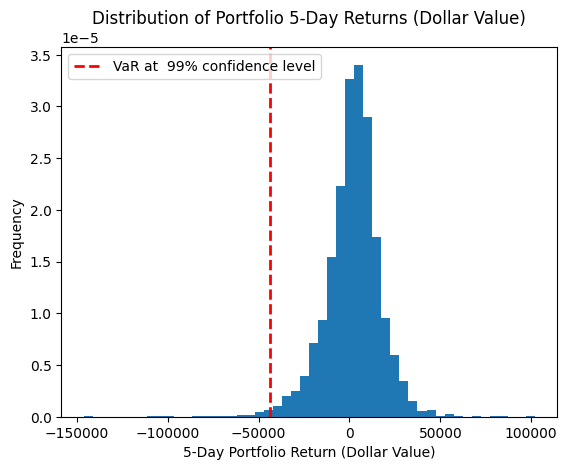

In [10]:
#Visualizes the historical returns and provides a dotted line to indicate 99% confidence interval VaR model.
return_window = days
range_returns = historical_returns.rolling(window=return_window).sum()
range_returns = range_returns.dropna()

range_returns_dollar = range_returns*portfolio_value

plt.hist(range_returns_dollar.dropna(), bins=50, density=True)
plt.xlabel(f'{return_window}-Day Portfolio Return (Dollar Value)')
plt.ylabel(f'Frequency')
plt.title(f'Distribution of Portfolio {return_window}-Day Returns (Dollar Value)')
plt.axvline(-VaR, color = 'r', linestyle = 'dashed', linewidth = 2, label = f'VaR at {confidence_interval: .0%} confidence level')
plt.legend()
plt.show()


# **VaR Function**
This function reads data from a given portfolio titled "Min Vol Sample Portfolio" and performs a historical VaR model. The data is prepared for analysis by the function titled clean_csv and data is collected from yahoo finance on each ticker to provide the Historical 5-day VaR model at a chosen level of confidence.

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

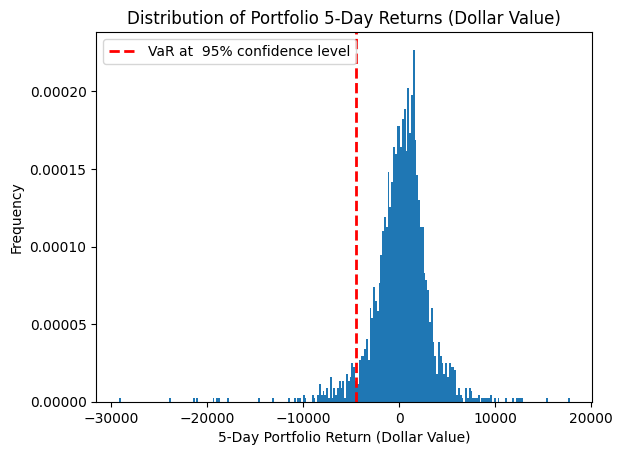

The 5-day Value at Risk is 4516.63 with 95.0% confidence level.


In [12]:
#Ticker data
years = 10
endDate = dt.datetime.now()
startDate = endDate - dt.timedelta(days=365*years)
#tickers = ['SPY','BND','GLD','QQQ','VTI']

adj_close = pd.DataFrame()

for ticker in tickers: 
    data = yf.download(ticker, start = startDate, end = endDate,auto_adjust=False) #auto_adjust=False needed to get adj close
    adj_close[ticker] = data['Adj Close']

adj_close

#cleans csv data
def clean_csv(data):
    data.set_index(0, inplace = True)
    data_t = data.transpose()
    data_t.set_index(np.nan, inplace = True)
    data_t = data_t.rename_axis('Ticker')
    col1 = data_t.columns[0] 
    data_t[col1]= data_t.iloc[:, 0].astype(float)
  
    return data_t

#grabs data from yfinance
def getdata(tickers):
    adj_close_df = pd.DataFrame()
    for ticker in tickers: 
        data = yf.download(ticker, start = startDate, end = endDate,auto_adjust=False) #auto_adjust=False needed to get adj close
        adj_close_df[ticker] = data['Adj Close']

    return adj_close_df
    
#VaR analysis as a callable function 
def VaR_Historical(file_name, confidence_interval, days):
    file_name = 'E:\\CSV Data\\'f'{file_name}' 
    data = pd.read_csv(f'{file_name}.csv', index_col = False, header = None)
    data = clean_csv(data)

    portfolio_value = data['Min Vol Sample Porfolio'].sum()
    weights = pd.Series(data['Min Vol Sample Porfolio']/data['Min Vol Sample Porfolio'].sum(), name='Weights')
    
    adj_close = getdata(data.index)
    
    log_returns = np.log(adj_close/adj_close.shift(1))
    log_returns = log_returns.dropna()

    historical_returns = (log_returns * weights).sum(axis =1)

    range_returns = historical_returns.rolling(window = days).sum()
    range_returns = range_returns.dropna()

    VaR = -np.percentile(range_returns, 100 - (confidence_interval *100))*portfolio_value

    return_window = days
    range_returns_dollar = range_returns*portfolio_value

    plt.hist(range_returns_dollar.dropna(), bins=250, density=True)
    plt.xlabel(f'{return_window}-Day Portfolio Return (Dollar Value)')
    plt.ylabel(f'Frequency')
    plt.title(f'Distribution of Portfolio {return_window}-Day Returns (Dollar Value)')
    plt.axvline(-VaR, color = 'r', linestyle = 'dashed', linewidth = 2, label = f'VaR at {confidence_interval: .0%} confidence level')
    plt.legend()
    plt.show()
    print(f'The {days}-day Value at Risk is {round(VaR,2)} with {confidence_interval*100}% confidence level.')
    
    return VaR
    
confidence_interval = .95
days = 5

file_name = "Min Vol Sample Portfolio"

#This line tells the function the file name, confience intervals, and days. Allowing for some customization of key variables.
var = VaR_Historical(file_name, confidence_interval, days)

